# Preprocess


In [262]:
using Statistics, LinearAlgebra, Random, DataFrames, Plots, StatsPlots, CSV, JSON, Dates, LowRankModels,SparseArrays
using Clustering
include("proxgrad.jl")

proxgrad_const

In [2]:
data = CSV.read("movies_metadata.csv");

thread = 1 warning: only found 10 / 24 columns on data row: 19730. Filling remaining columns with `missing`
thread = 1 warning: only found 15 / 24 columns on data row: 19731. Filling remaining columns with `missing`
thread = 1 warning: only found 10 / 24 columns on data row: 29503. Filling remaining columns with `missing`
thread = 1 warning: only found 15 / 24 columns on data row: 29504. Filling remaining columns with `missing`
thread = 1 warning: only found 10 / 24 columns on data row: 35587. Filling remaining columns with `missing`
thread = 1 warning: only found 15 / 24 columns on data row: 35588. Filling remaining columns with `missing`


In [3]:
names(data)

24-element Array{Symbol,1}:
 :adult                
 :belongs_to_collection
 :budget               
 :genres               
 :homepage             
 :id                   
 :imdb_id              
 :original_language    
 :original_title       
 :overview             
 :popularity           
 :poster_path          
 :production_companies 
 :production_countries 
 :release_date         
 :revenue              
 :runtime              
 :spoken_languages     
 :status               
 :tagline              
 :title                
 :video                
 :vote_average         
 :vote_count           

In [4]:
"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    result = zeros(size(column)[1], size(cats)[1])
    new_cats = Dict()
    for (n, f) in enumerate(cats)
       new_cats[f] = n
    end
    
    for i in 1:size(column)[1]
        index = get(new_cats, column[i], 0)
        if index != 0
            result[i, index] = 1
        end
    end
    result
end

onehot

In [5]:
"Computes a manyhot vector for every entry in an array of arrays given a set of categories cats"
function manyhot(column)
    cats = Set()
    for set in column
        for item in set
            push!(cats, item)
        end
    end
    cats = unique(cats)
    
    result = zeros(size(column)[1], size(cats)[1])
    new_cats = Dict()
    for (n, f) in enumerate(cats)
       new_cats[f] = n
    end
    
    for i in 1:size(column)[1]
        set_of_descriptions = Set(column[i])
        for description in set_of_descriptions
            index = get(new_cats, description, 0)
            if index != 0
                result[i, index] = 1
            end
        end
    end
    result
end

manyhot

### Preprocess genre using many-hot encoding

In [6]:
function preprocess_json(d)
    if ismissing(d) || d == "False"
        return Set()
    end
    x = d
    x = replace(x, "\"" => "\'")
    x = replace(x, "\\xa0" => " ")
    x = replace(x, "'name'" => "\"name\"")
    x = replace(x, "'id'" => "\"id\"")
    x = replace(x, ": '" => ": \"")
    x = replace(x, "'}" => "\"}")
    x = replace(x, "'," => "\",")
    x = replace(x, "Orlenok\"" => "Orlenok'")
    x = replace(x, "'iso_3166_1'" => "\"iso_3166_1\"")
    result = Set{String}()
    try
        for dic in JSON.parse(x)
            push!(result, dic["name"])
        end
    catch err
        println(d)
        println(x)
        println("=============================")
        return Set()
    end
    return result
end

preprocess_json (generic function with 1 method)

In [7]:
genres = manyhot(map(preprocess_json,data[:,:genres]))

45466×32 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  1

### Preprocess production company using many-hot encoding

In [8]:
production_companies = manyhot(map(preprocess_json,data[:,:production_companies]))
size(production_companies)

(45466, 23537)

There are so many production companies and we don't want to overfit our data, so we exclude it for now.

### Production countries using many-hot encoding

In [9]:
production_countries = manyhot(map(preprocess_json,data[:,:production_countries]))

4.3
4.3
6.0
6.0
7.0
7.0


45466×160 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  

### Preprocess popularity to float type

In [10]:
function parse_string_to_float(x)
    if ismissing(x)
        return 0
    end
    result = 0
    try
        result = parse(Float64, x)
    catch
        println(x)
        println("=========")
    end
    return result
end

parse_string_to_float (generic function with 1 method)

In [11]:
popularity = map(parse_string_to_float,data[:,:popularity])




Beware Of Frost Bites


45466-element Array{Real,1}:
 21.946943
 17.015539
 11.7129  
  3.859495
  8.387519
 17.924927
  6.677277
  2.561161
  5.23158 
 14.686036
  6.318445
  5.430331
 12.140733
  ⋮       
  0.139936
  0.225051
  0.222814
  0.076061
  0.38645 
  0.661558
  5.683753
  0.072051
  0.178241
  0.903007
  0.003503
  0.163015

### Preprocess budget with boolean encoding

In [12]:
budget = data[:,:budget]
Random.seed!(3)
randlist = filter(x -> x != "0", data[:,:budget])
rand_num = length(randlist)
budget_rep = replace(budget, "/ff9qCepilowshEtG2GYWwzt2bs4.jpg"=>"0")
budget_rep = replace(budget_rep, "/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg"=>"0")
budget_rep = replace(budget_rep, "/zaSf5OG7V8X8gqFvly88zDdRm46.jpg"=>"0")
budget_rep = replace(budget_rep, "0"=>randlist[rand(1:rand_num)], NaN=>randlist[rand(1:rand_num)])
budget_repint = parse.(Float64, string.(budget_rep)) / 10^6
n = length(budget_repint)
budget_feature = zeros(n, 2)
for r in 1:n
    if budget_repint[r] > 20
        budget_feature[r,:] = [1,1]
    elseif budget_repint[r] > 1
        budget_feature[r,:] = [1,0]
    else
        budget_feature[r,:] = [0,0]
    end
end

In [13]:
sum(budget_feature)/45466

1.8248141468349977

### Preprocess runtime using boolean encoding, change missing to mean value

In [120]:
time1 = data[:, :runtime]
valid = filter(x -> ! ismissing(x), time1)
mean_val = mean(valid)
for i in 1:size(time1, 1)
    if ismissing(time1[i]) || time1[i] == 0
        time1[i] = mean_val
    end
end

min_val = minimum(time1)
max_val = maximum(time1)
q_val = quantile(time1, [0.25, 0.5, 0.75])

runtime = zeros(size(time1, 1), 3) # the new matrix with many code
for i in 1:size(time1, 1)
    t = time1[i]
    runtime[i, :] = Int.([t>=q_val[1], t>=q_val[2], t>=q_val[3]])
end
runtime

45466×3 Array{Float64,2}:
 0.0  0.0  0.0
 1.0  1.0  0.0
 1.0  1.0  0.0
 1.0  1.0  1.0
 1.0  1.0  0.0
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  0.0
 1.0  1.0  0.0
 1.0  1.0  1.0
 1.0  1.0  0.0
 1.0  0.0  0.0
 0.0  0.0  0.0
 ⋮            
 0.0  0.0  0.0
 1.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 1.0  1.0  0.0
 1.0  0.0  0.0
 1.0  1.0  1.0
 1.0  0.0  0.0
 1.0  0.0  0.0
 0.0  0.0  0.0

### Preprocess runtime using one-hot encoding on month/quarter

In [15]:
date = data[:, :release_date]
months = Int.(zeros(size(date, 1)))
for i in 1:size(date, 1)
    x = date[i]
    if ismissing(x)
        months[i] = rand(1:12,1)[1]
    else
        months[i] = Dates.month(x)
    end
end

release_date = zeros(size(months, 1), 4)
for i in 1:length(months)
    d = months[i]
    release_date[i, :] = Int.([d in 1:3, d in 4:6, d in 7:9, d in 10:12])
end
release_date

45466×4 Array{Float64,2}:
 0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0
 ⋮                 
 1.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0
 0.0  1.0  0.0  0.0

# Approach 1: Linear Regression: Solving Least Squares

## Experiment

### Compute true label y using IMDB's weighted rating

We use the TMDB Ratings to come up with our Top Movies Chart. We will use IMDB's weighted rating formula to construct my chart. Mathematically, it is represented as follows:

Weighted Rating (WR) = ($\frac{v}{v+m}\times R + \frac{m}{v+m}\times C$)
, where

- v is the number of votes for the movie
- m is the minimum votes required to be listed in the chart
- R is the average rating of the movie
- C is the mean vote across the whole report

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [85]:
vote_avg = data[:, :vote_average]
vote_c = data[:, :vote_count]
mean_c = mean(map(z -> ismissing(z) ? 0 : z, vote_c))
mean_a = mean(map(z -> ismissing(z) ? 0 : z, vote_avg))
vote_avg = map(z -> ismissing(z) ? mean_a : z, vote_avg)
vote_c = map(z -> ismissing(z) ? mean_c : z, data[:, :vote_count])
m = quantile(vote_c, 0.95)
C = mean(vote_avg)
v = vote_c
R = vote_avg
weighted_rat = (v./(v.+m) .* R) .+ (m./(m.+v) .* C)
y = copy(weighted_rat) .* 10

45466-element Array{Float64,1}:
 75.45611855033185 
 67.04697404803844 
 57.72510389206552 
 56.53227871994322 
 56.415283677385155
 73.10743544401484 
 57.6093490582922  
 55.976967877291784
 55.843641910741994
 63.38379565120776 
 58.955311531020854
 56.44889067379176 
 63.498072216228124
  ⋮                
 56.10779890132746 
 56.20829621351675 
 56.30554243634057 
 56.245492532997005
 56.21385479299241 
 56.133348755039556
 56.228327071785635
 56.14484961760425 
 56.41436375787852 
 55.93399288516986 
 56.182071172918604
 56.182071172918604

Therefore, to qualify to be considered for the chart, a movie has to have at least $m=434$ votes on TMDB. We also see that the average rating for a movie on TMDB is 56.18 on a scale of 0 to 100, and the average vote count is 109.897. Note that we have enlarged the rating scale by 10 times to make prediction MSE's more pronounced.

### Separate data into training, validation and test datasets by 7:2:1

In [86]:
function separate_dataset(y, dataset)
    Random.seed!(5)
    new_dataset = hcat(y, dataset)
    new_dataset = new_dataset[shuffle(1:end), :]
    
    train_proportion = 0.7
    valid_proportion = 0.2
    n = size(dataset, 1)
    println("Size of dataset: ", string(n))
    
    ntrain = convert(Int, round(train_proportion*n))
    ntest = convert(Int, round((1-train_proportion-valid_proportion)*n))

    target = new_dataset[:, 1]
    train_x = new_dataset[1:ntrain, 2:end]
    train_y = target[1:ntrain]
    valid_x = new_dataset[ntrain+1:(n-ntest), 2:end]
    valid_y = target[ntrain+1:(n-ntest)]
    test_x = new_dataset[(n-ntest+1):end, 2:end]
    test_y = target[(n-ntest+1):end]
    return train_x, train_y, valid_x, valid_y, test_x, test_y
end

separate_dataset (generic function with 1 method)

### Calculate least square

In [18]:
"""This function just computes the mean squared error."""
function MSE(y, pred)
    n = size(y)[1]
    err = 0
    for i in 1:n
        err += (y[i] - pred[i])^2
    end
    return err/n
end

"""This function plots the main diagonal; 
for a "predicted vs true" plot with perfect predictions,
all data lies on this line"""
function plotDiagonal(xmin, xmax; legend="")
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color=:black, label=[legend])
end

"""This helper funciton plots x vs, y and labels the axes."""
function plotdata(x,y,xname, yname; title="", margin=.05, plotDiag=true, zeromin=false)
    scatter(x,y, label="data")
    xlabel!(xname)
    ylabel!(yname)
    title!(title)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x)-margin*range_x, maximum(x)+margin*range_x, legend="true preds")
    end
    if zeromin
        ylims!((0.0,maximum(y)+margin*range_y))
        xlims!((0.0,maximum(x)+margin*range_x))
    else
        ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
        xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
    end
end

"""This function plots the predicted labels vs the actual labels
(We only plots the first 1000 points to avoid slow plots.)"""
function plot_pred_true(test_pred, test_y; title = "", zeromin = true, max_points = 1000)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted (\$)", "True (\$)", title=title, zeromin=zeromin)
end

plot_pred_true

In [19]:
function calculate_MSE(train_x, train_y, test_x, test_y)
    # The weights of your linear equation (compute via least squares)
    w = train_x\train_y

    train_pred = train_x*w
    test_pred = test_x*w

    train_MSE = MSE(train_y, train_pred)
    test_MSE = MSE(test_y, test_pred)
    
    println("Train MSE\t", train_MSE)
    println("Validation MSE \t", test_MSE)
    return test_pred
end

calculate_MSE (generic function with 1 method)

### First, let's see how individual feature performs

In [20]:
# 建议不要跑 电脑可能会炸😂
# println("Feature: Production Countries")
# dataset = hcat(ones(size(data,1)), production_countries)
# train_x, train_y, test_x, test_y = separate_dataset(y, dataset)
# test_pred = calculate_MSE(train_x, train_y, test_x, test_y)
# println("=====================")

In [21]:
println("Feature: Budget")
dataset = hcat(ones(size(data,1)), budget_feature)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
println("Feature: Popularity")
dataset = hcat(ones(size(data,1)), popularity)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
println("Feature: Release Date")
dataset = hcat(ones(size(data,1)), release_date)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
println("Feature: Runtime")
dataset = hcat(ones(size(data,1)), runtime)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
println("Feature: Genres")
dataset = hcat(ones(size(data,1)), genres)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")

Feature: Budget
Size of dataset: 45466
Train MSE	5.156889673372362
Validation MSE 	5.51899675960354
Feature: Popularity
Size of dataset: 45466
Train MSE	4.312549540312432
Validation MSE 	4.316298882915048
Feature: Release Date
Size of dataset: 45466
Train MSE	5.332957721456701
Validation MSE 	5.771083828236537
Feature: Runtime
Size of dataset: 45466
Train MSE	5.03932152613925
Validation MSE 	5.447464439268874
Feature: Genres
Size of dataset: 45466
Train MSE	5.1084894729629875
Validation MSE 	5.5382583359176705


### Closer look into Popularity feature

It looks like Popularity has the lowest individual validation error, so we examine Popularity feature first. As the first step, we plot Popularity against real value y to check their relationship.

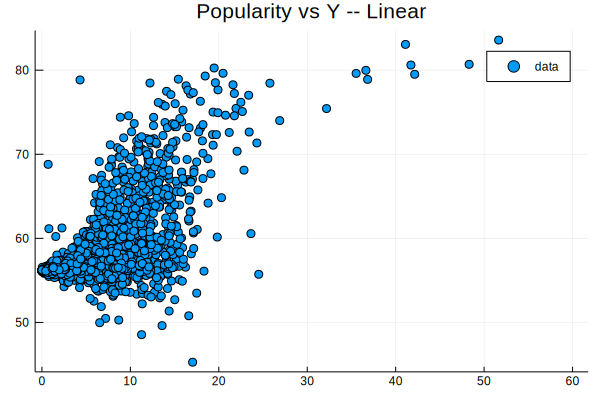

In [22]:
scatter(popularity[1:2000], y[1:2000], title="Popularity vs Y -- Linear", label="data", xlim=[1,60])

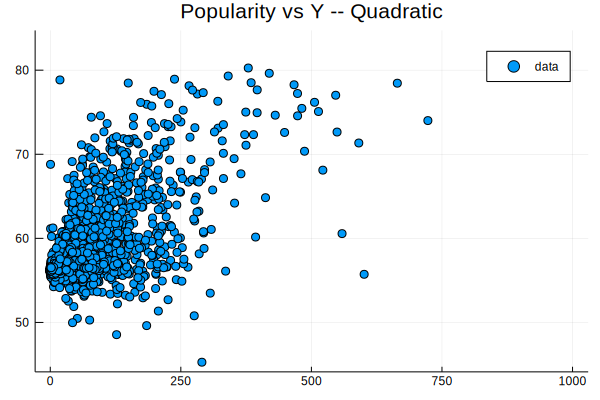

In [23]:
scatter(popularity[1:2000].^2, y[1:2000], title="Popularity vs Y -- Quadratic", label="data",xlim=[1,1000])

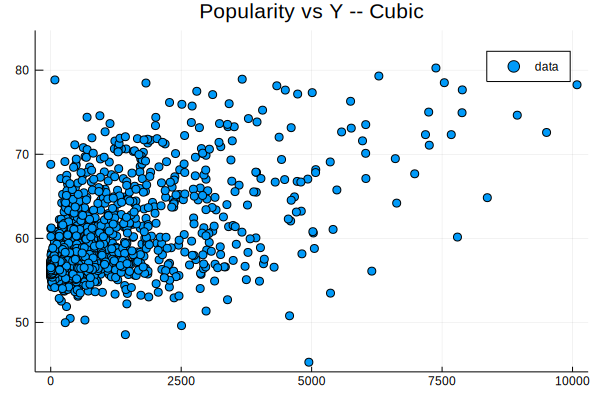

In [24]:
scatter(popularity[1:2000].^3, y[1:2000], title="Popularity vs Y -- Cubic", label="data", xlim=[1,10^4])

From the above scatter plots, we see that Popularity and y is NOT simply linearly related. In fact, quadratic and cubic models, or even quartic model, might give better linear regression results. As follows, we fit all of them to see which has the smallest validation error.

Feature: Popularity -- Linear Fit
Size of dataset: 45466
Train MSE	4.312549540312432
Validation MSE 	4.316298882915048


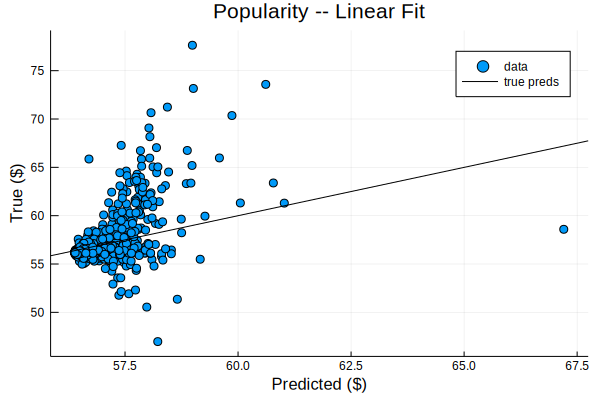

In [25]:
println("Feature: Popularity -- Linear Fit")
dataset = hcat(ones(size(data,1)), popularity)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Popularity -- Linear Fit", zeromin=false)

Feature: Popularity -- Quadratic Fit
Size of dataset: 45466
Train MSE	3.739717256197036
Validation MSE 	3.859219052520295


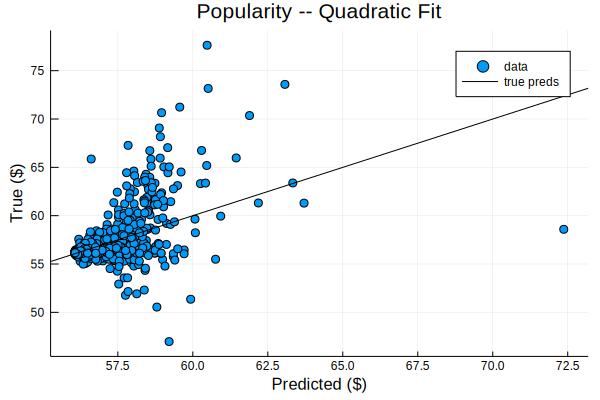

In [26]:
println("Feature: Popularity -- Quadratic Fit")
dataset = hcat(ones(size(data,1)), popularity, popularity.^2)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Popularity -- Quadratic Fit", zeromin=false)

Feature: Popularity -- Cubic Fit
Size of dataset: 45466
Train MSE	3.5773601610781642
Validation MSE 	3.7751873539057144


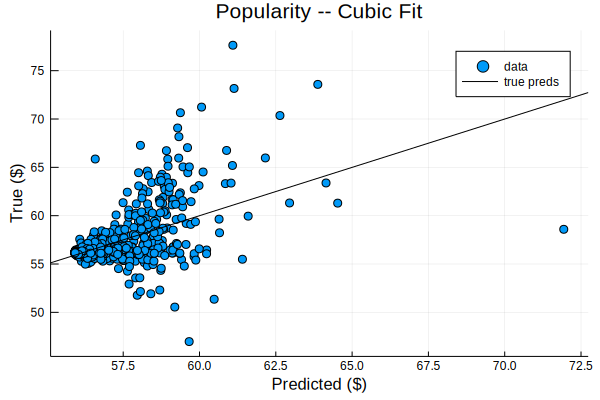

In [27]:
println("Feature: Popularity -- Cubic Fit")
dataset = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Popularity -- Cubic Fit", zeromin=false)

Feature: Popularity -- Quartic Fit
Size of dataset: 45466
Train MSE	3.569451614571739
Validation MSE 	3.7843233978060242


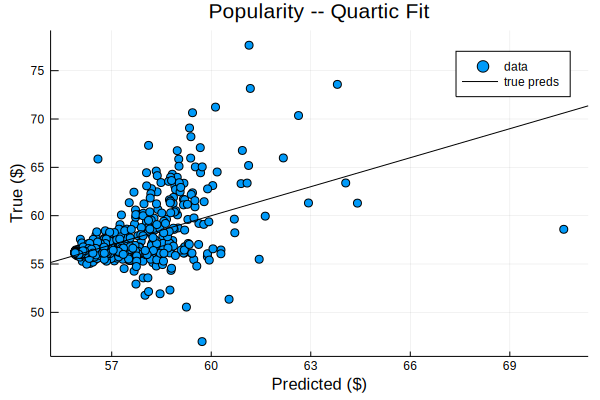

In [28]:
println("Feature: Popularity -- Quartic Fit")
dataset = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3, popularity.^4)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Popularity -- Quartic Fit", zeromin=false)

The quartic model has higher error validation error than the cubic model, so we stop at order 3. The cubic model has the smallest validation error, so we go with the 3rd order model.

### Popularity with Runtime and Budget features

Since Runtime and Budget has the next lowest validation errors, we try adding them to the $\textbf{cubic}$ Popularity model and see if they produce good results.

Popularity + Runtime
Size of dataset: 45466
Train MSE	3.492309862723996
Validation MSE 	3.692392209220625


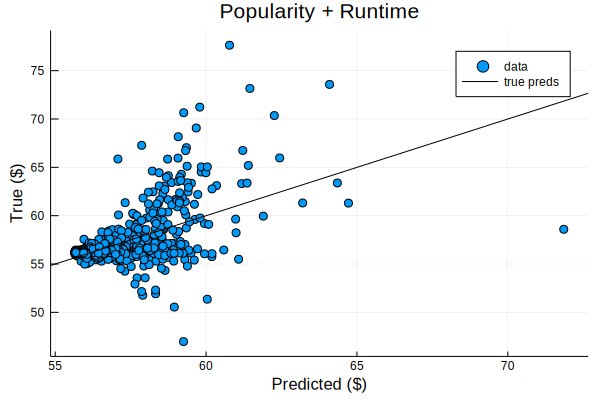

In [29]:
println("Popularity + Runtime")
dataset = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3, runtime)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Popularity + Runtime", zeromin=false)

Popularity + Runtime Cubic
Size of dataset: 45466
Train MSE	3.495170968928914
Validation MSE 	3.685832738721808


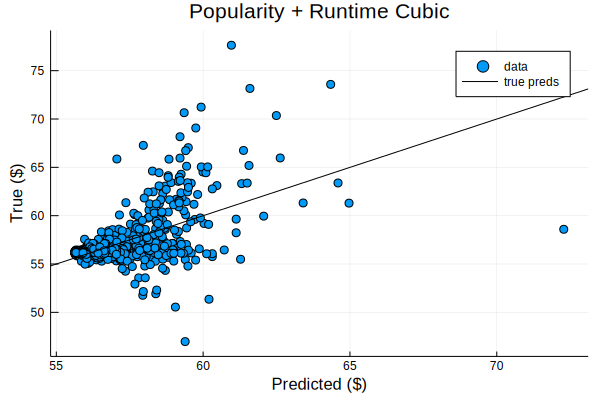

In [30]:
println("Popularity + Runtime Cubic")
dataset = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3, runtime, runtime.^2, runtime.^3)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Popularity + Runtime Cubic", zeromin=false)

Popularity + Budget
Size of dataset: 45466
Train MSE	3.5682792651723245
Validation MSE 	3.7594442048848196


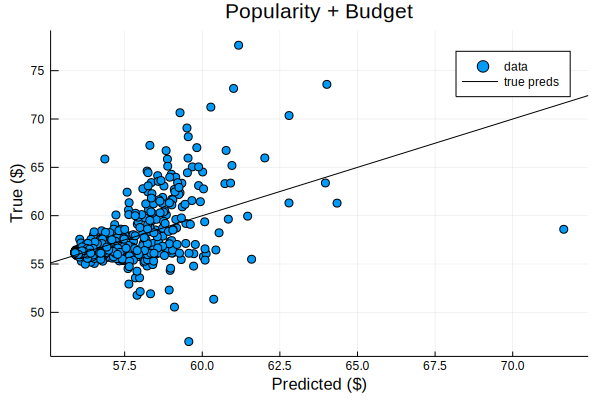

In [31]:
println("Popularity + Budget")
dataset = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3, budget_feature)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Popularity + Budget", zeromin=false)

Popularity + Budget pseudo-multivariate
Size of dataset: 45466
Train MSE	3.522244983356812
Validation MSE 	3.656651973683396


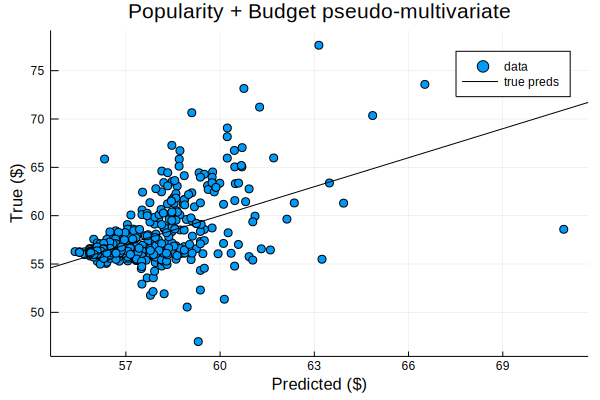

In [32]:
println("Popularity + Budget pseudo-multivariate")
dataset = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3, budget_feature, budget_feature .^2,
popularity .* budget_feature, popularity.^2 .* budget_feature)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Popularity + Budget pseudo-multivariate", zeromin=false)

Popularity + Runtime + Budget
Size of dataset: 45466
Train MSE	3.4839848281060175
Validation MSE 	3.678765159904359


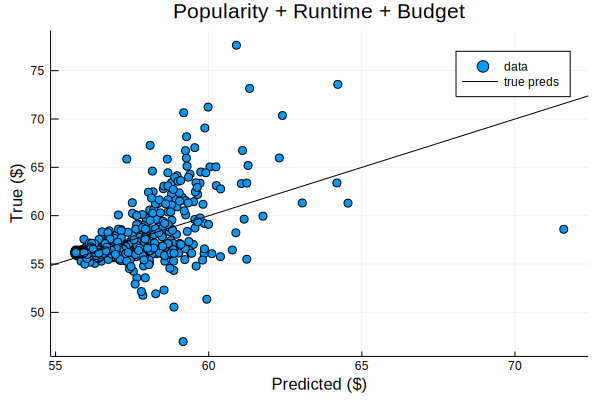

In [33]:
println("Popularity + Runtime + Budget")
dataset = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3, runtime, budget_feature)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Popularity + Runtime + Budget", zeromin=false)

Popularity + Runtime + Budget pseudo-multivariate
Size of dataset: 45466
Train MSE	3.426348612618145
Validation MSE 	3.5777903210878175


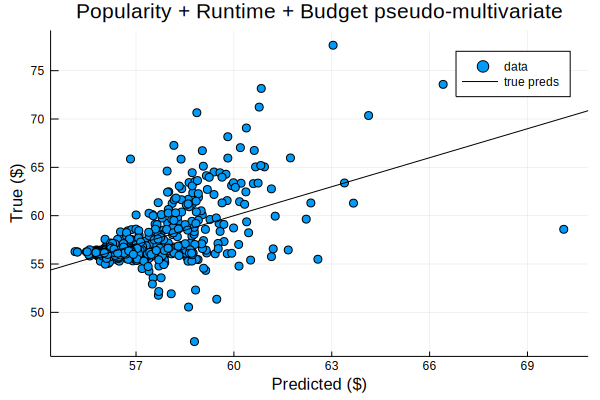

In [34]:
println("Popularity + Runtime + Budget pseudo-multivariate")
dataset = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3, runtime, budget_feature, 
budget_feature .^2, popularity .* budget_feature, popularity.^2 .* budget_feature)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Popularity + Runtime + Budget pseudo-multivariate", zeromin=false)

Among all three models above, it seems that the cubic popularity, runtime and budget using a pseudo-multivariate polynomial fit combined produce the best result. So next we try adding Genres and Release Date.

### Adding Genres and Release Date

Popularity + Runtime + Budget + Genres
Size of dataset: 45466
Train MSE	245.73121225436327
Validation MSE 	3.6389474557370396


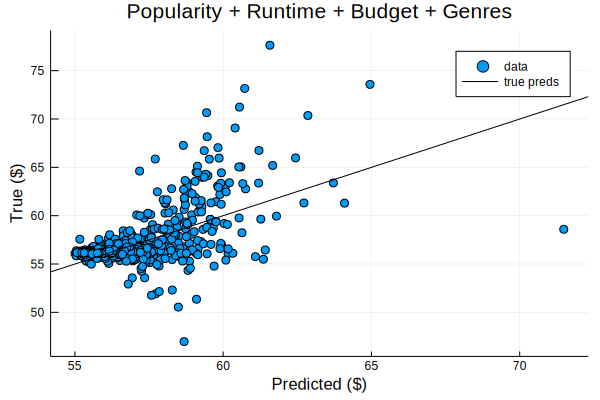

In [35]:
println("Popularity + Runtime + Budget + Genres")
dataset = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3, genres, runtime, budget_feature)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Popularity + Runtime + Budget + Genres", zeromin=false)

Popularity + Runtime + Budget + Release Date
Size of dataset: 45466
Train MSE	3.4813047466233034
Validation MSE 	3.674248342579983


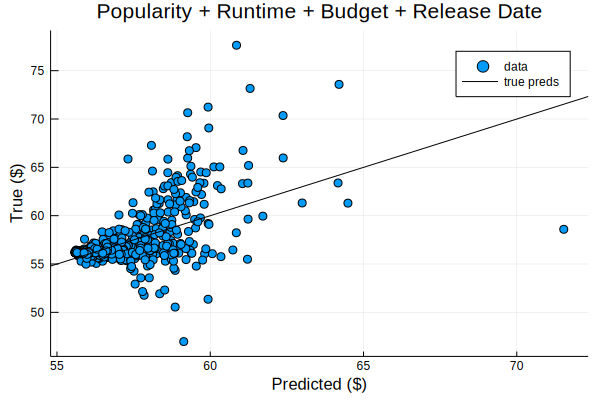

In [36]:
println("Popularity + Runtime + Budget + Release Date")
dataset = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3, runtime, budget_feature, release_date)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Popularity + Runtime + Budget + Release Date", zeromin=false)

Popularity + Runtime + Budget + Release Date + Genres
Size of dataset: 45466
Train MSE	3.5300970227602217
Validation MSE 	3.5520932071138867


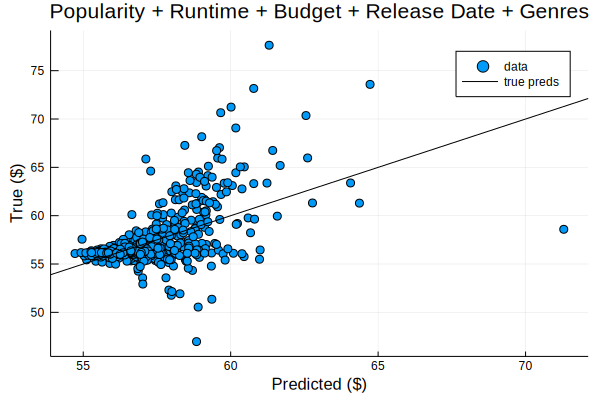

In [37]:
println("Popularity + Runtime + Budget + Release Date + Genres")
dataset = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3, runtime, budget_feature, release_date, genres)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Popularity + Runtime + Budget + Release Date + Genres", zeromin=false)

It looks like the model gets really bad when the Genres feature is added. But Release Date seems to improve the model a little bit, so we keep it in the model. So for now, the features we obtain are cubic popularity, runtime, budget and release date. Make this our first model.

In [38]:
println("Model I: Popularity + Popularity^2 + Popularity^3 + Runtime + Budget + Release Date")
println("---------------------")
dataset1 = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3, runtime, budget_feature, release_date)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset1)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
w1 = train_x\train_y
println("=====================")

Model I: Popularity + Popularity^2 + Popularity^3 + Runtime + Budget + Release Date
---------------------
Size of dataset: 45466
Train MSE	3.4813047466233034
Validation MSE 	3.674248342579983


Try adding the pseudo-multivariate polynomial fit for budget and popularity. That is "Popularity + Budget pseudo-multivariate + runtime + Budget + Release Date". Seems to improve a little bit. Call it Model I beta.

Model I Beta
Size of dataset: 45466
Train MSE	3.422362368565167
Validation MSE 	3.572925452106735


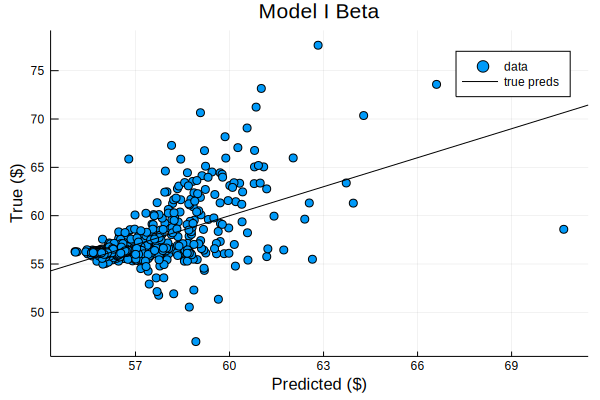

In [39]:
println("Model I Beta")
dataset1_beta = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3, runtime, budget_feature, 
budget_feature .^2, popularity .* budget_feature, popularity.^2 .* budget_feature, release_date)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset1_beta)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
w1_beta = train_x\train_y
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Model I Beta", zeromin=false)

### Adding Production Countries

Next we try adding the Production Countries feature into our model. Note that the Production Countries has 160 columns, compared to 13 columns in our current model's dataset. The sparsity makes $X^TX$ a singular matrix, so instead of solving the normal equation, we turn to SVD to compute $w$.

In [40]:
println("Size of current dataset:\t", size(dataset1))
println("Size of Production Countries:\t", size(production_countries))

Size of current dataset:	(45466, 13)
Size of Production Countries:	(45466, 160)


In [41]:
function calculate_MSE_SVD(train_x, train_y, test_x, test_y)
    # The weights of your linear equation (compute via SVD)
    U, S, V = svd(train_x)
    w = V*inv(Diagonal(S))*transpose(U)*train_y

    train_pred = train_x*w
    test_pred = test_x*w

    train_MSE = MSE(train_y, train_pred)
    test_MSE = MSE(test_y, test_pred)
    
    println("Train MSE\t", train_MSE)
    println("Validation MSE \t", test_MSE)
    return test_pred
end

calculate_MSE_SVD (generic function with 1 method)

Model I + Production Countries
---------------------
Size of dataset: 45466
Train MSE	7.187836203377891e6
Validation MSE 	4.7220136067607807e24


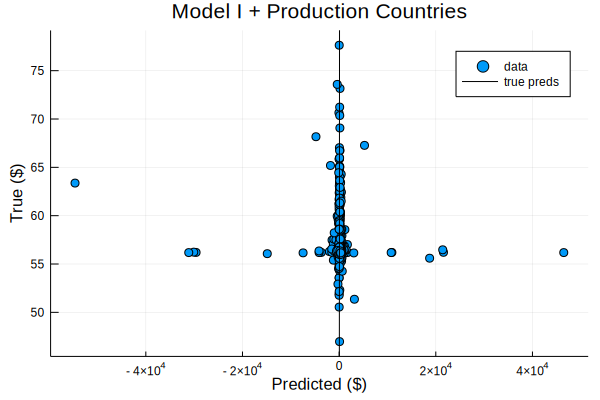

In [42]:
println("Model I + Production Countries")
println("---------------------")
dataset = hcat(dataset1, production_countries)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset)
valid_pred = calculate_MSE_SVD(train_x, train_y, valid_x, valid_y)
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Model I + Production Countries", zeromin=false)

Adding in the production countries makes the data even more messy and results even worse. However, a quick examination into the Production Countries feature reveals to us that among the 45,466 movies, 211,53 of them are produced in the US. So instead of using many-hot encoding, we replace this feature with a single vector indicating whether the movie is produced in the US or not. We make this our new model.

Model II: Model I + New Production Countries
---------------------
Size of dataset: 45466
Train MSE	3.471749323916
Validation MSE 	3.6590212880876067


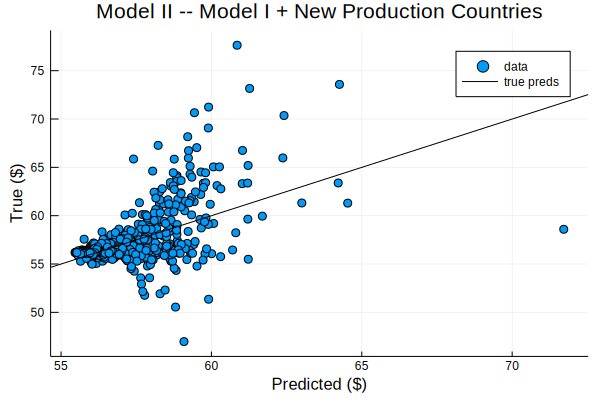

In [43]:
println("Model II: Model I + New Production Countries")
println("---------------------")
production_countries_new = production_countries[:,1]
dataset2 = hcat(dataset1, production_countries_new)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset2)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Model II -- Model I + New Production Countries", zeromin=false)

This one looks good. Try with Model I Beta, and see if there is a better result. Call this Model II Beta.

Model II Beta: Model I Beta + New Production Countries
---------------------
Size of dataset: 45466
Train MSE	3.4134302219575536
Validation MSE 	3.5600685729569883


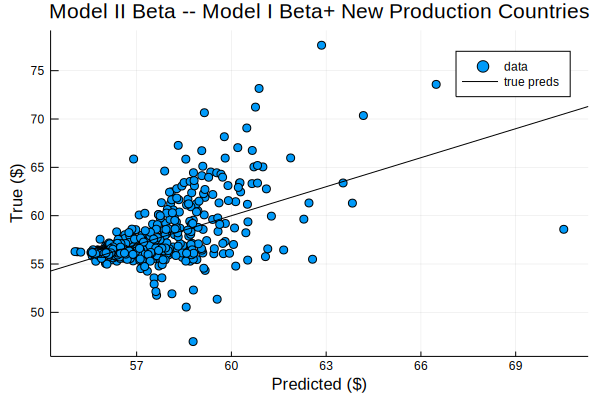

In [44]:
println("Model II Beta: Model I Beta + New Production Countries")
println("---------------------")
production_countries_new = production_countries[:,1]
dataset2_beta = hcat(dataset1_beta, production_countries_new)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset2_beta)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Model II Beta -- Model I Beta+ New Production Countries", zeromin=false)

From above we see that Model II is slightly better than Model I with lower errors.

### Model without Runtime and Release Date but with Genres

Instead of fitting Runtime and Release Date, we now try fitting with Genres. Note that Model III and Model III Beta (as fitted below）using cubic popularity, genres and budget features have even lower validation error than Model I and II. Model III Beta has the lowest validation error so far.

Note that the validation error is smaller than the training error in Model III and Model III Beta. This is possibly because there is a few big outliers existent in the training set, and these two models happen to capture these outliers. The outliers are probably in Genres feature, because Model III and III Beta differ from previous models particularly by adding in Genres.

Model III: Popularity + Popularity^2 + Popularity^3 + Genres + Budget
---------------------
Size of dataset: 45466
Train MSE	3.7860833722080147
Validation MSE 	3.6046759805613604


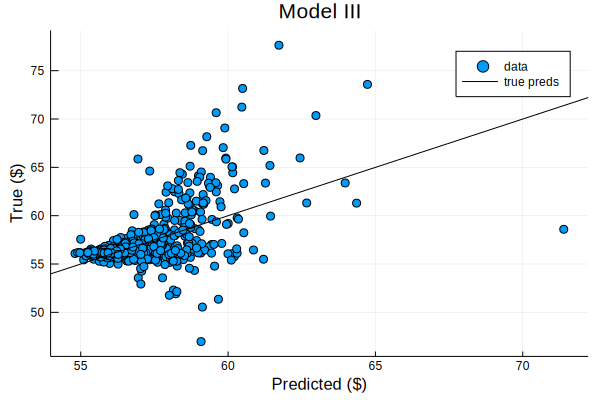

In [45]:
println("Model III: Popularity + Popularity^2 + Popularity^3 + Genres + Budget")
println("---------------------")
dataset3 = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3, genres, budget_feature)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset3)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Model III", zeromin=false)

Model III Beta
---------------------
Size of dataset: 45466
Train MSE	3.5226635728999667
Validation MSE 	3.520186235587502


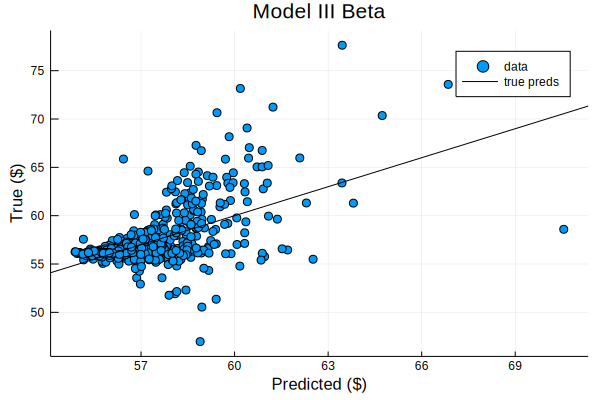

In [46]:
println("Model III Beta")
println("---------------------")
dataset3_beta = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3, genres, budget_feature, 
budget_feature .^2, popularity .* budget_feature, popularity.^2 .* budget_feature)
train_x, train_y, valid_x, valid_y, _, _ = separate_dataset(y, dataset3_beta)
valid_pred = calculate_MSE(train_x, train_y, valid_x, valid_y)
println("=====================")
plot_pred_true(valid_pred, valid_y, title="Model III Beta", zeromin=false)

## Now let's see how these models actually perform

### Compute Test Errors

In [47]:
println("Model I")
println("---------------------")
train_x, train_y, valid_x, valid_y, test_x, test_y = separate_dataset(y, dataset1)
w1 = train_x\train_y
test_pred = test_x*w1
println("Test error:\t", mean((test_pred.- test_y).^2))
println("=====================")
# plot_pred_true(test_pred, test_y, title="Model I Test Error", zeromin=false)

Model I
---------------------
Size of dataset: 45466
Test error:	3.614258865779606


In [48]:
println("Model I Beta")
println("---------------------")
train_x, train_y, valid_x, valid_y, test_x, test_y = separate_dataset(y, dataset1_beta)
w1_beta = train_x\train_y
test_pred = test_x*w1_beta
println("Test error:\t", mean((test_pred.- test_y).^2))
println("=====================")
# plot_pred_true(test_pred, test_y, title="Model I Beta Test Error", zeromin=false)

Model I Beta
---------------------
Size of dataset: 45466
Test error:	3.585954274112122


In [49]:
println("Model II")
println("---------------------")
train_x, train_y, valid_x, valid_y, test_x, test_y = separate_dataset(y, dataset2)
w2 = train_x\train_y
test_pred = test_x*w2
println("Test error:\t", mean((test_pred.- test_y).^2))
println("=====================")
# plot_pred_true(test_pred, test_y, title="Model II Test Error", zeromin=false)

Model II
---------------------
Size of dataset: 45466
Test error:	3.594756922065391


In [50]:
println("Model II Beta")
println("---------------------")
train_x, train_y, valid_x, valid_y, test_x, test_y = separate_dataset(y, dataset2_beta)
w2_beta = train_x\train_y
test_pred = test_x*w2_beta
println("Test error:\t", mean((test_pred.- test_y).^2))
println("=====================")
# plot_pred_true(test_pred, test_y, title="Model II Beta Test Error", zeromin=false)

Model II Beta
---------------------
Size of dataset: 45466
Test error:	3.5693105106588354


In [51]:
println("Model III")
println("---------------------")
train_x, train_y, valid_x, valid_y, test_x, test_y = separate_dataset(y, dataset3)
w3 = train_x\train_y
test_pred = test_x*w3
println("Test error:\t", mean((test_pred.- test_y).^2))
println("=====================")
# plot_pred_true(test_pred, test_y, title="Model III Test Error", zeromin=false)

Model III
---------------------
Size of dataset: 45466
Test error:	3.5559679386266865


Model III Beta
---------------------
Size of dataset: 45466
Test error:	3.5414735713208314


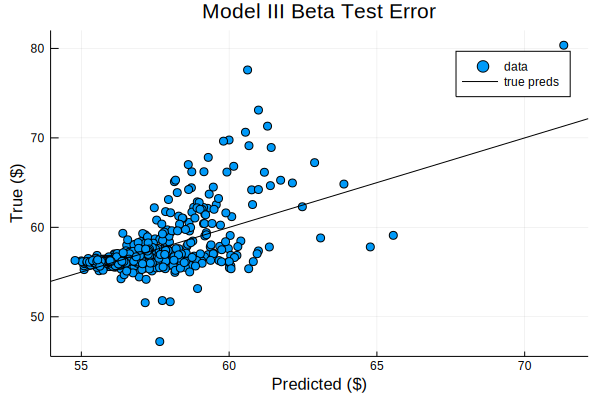

In [52]:
println("Model III Beta")
println("---------------------")
train_x, train_y, valid_x, valid_y, test_x, test_y = separate_dataset(y, dataset3_beta)
w3_beta = train_x\train_y
test_pred = test_x*w3_beta
println("Test error:\t", mean((test_pred.- test_y).^2))
println("=====================")
plot_pred_true(test_pred, test_y, title="Model III Beta Test Error", zeromin=false)

Indeed, Model III Beta has the lowest test error among all models.

# Approach 2: ERM

### Create the X and y, referencing the 6 models tried above (for comparision purposes)

In [87]:
dataset1 = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3, runtime, budget_feature, release_date)
tr_x_1, tr_y_1, val_x_1, val_y_1, _, _ = separate_dataset(y, dataset1)

dataset1beta = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3, runtime, budget_feature, 
    budget_feature .^2, popularity .* budget_feature, popularity.^2 .* budget_feature, release_date)
tr_x_1beta, tr_y_1beta, val_x_1beta, val_y_1beta, _, _ = separate_dataset(y, dataset1beta)

dataset2 = hcat(dataset1, production_countries_new)
tr_x_2, tr_y_2, val_x_2, val_y_2, _, _ = separate_dataset(y, dataset2)

dataset2_beta = hcat(dataset1_beta, production_countries_new)
tr_x_2beta, tr_y_2beta, val_x_2beta, val_y_2beta, _, _ = separate_dataset(y, dataset2_beta)

dataset3 = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3, genres, budget_feature)
tr_x_3, tr_y_3, val_x_3, val_y_3, _, _ = separate_dataset(y, dataset3)

dataset3_beta = hcat(ones(size(data,1)), popularity, popularity.^2, popularity.^3, genres, budget_feature, 
budget_feature .^2, popularity .* budget_feature, popularity.^2 .* budget_feature)
tr_x_3beta, tr_y_3beta, val_x_3beta, val_y_3beta, _, _ = separate_dataset(y, dataset3_beta)

Size of dataset: 45466
Size of dataset: 45466
Size of dataset: 45466
Size of dataset: 45466
Size of dataset: 45466
Size of dataset: 45466


(Real[1.0 0.255811 … 0.065439267721 0.065439267721; 1.0 0.161184 … 0.025980281855999997 0.025980281855999997; … ; 1.0 8.768806 … 76.891958665636 76.891958665636; 1.0 1.175226 … 1.3811561510760002 1.3811561510760002], Real[56.099769418612475, 56.24264080424372, 56.74799331414729, 56.04053449265032, 56.167851342733634, 56.37543197583686, 56.20687520466957, 56.68398554477204, 55.264632606476425, 56.40942687090962  …  56.614817347115036, 56.86635155855623, 55.81980113131514, 56.72781390050236, 56.350698979771664, 64.82437620088255, 56.684514736710796, 56.182071172918604, 55.86645267638943, 56.284853328667296], Real[1.0 2.004745 … 4.019002515025001 0.0; 1.0 0.964849 … 0.930933592801 0.930933592801; … ; 1.0 3.249017 … 10.556111466288998 10.556111466288998; 1.0 0.167618 … 0.028095793923999995 0.028095793923999995], Real[56.665498327794666, 56.199594655773815, 56.116444023423064, 56.220519320644556, 56.12156826449442, 56.32981621245974, 55.32124470604114, 56.31674842450928, 59.12760427737506, 

### Try among different combinations of loss functions and regularizations for each model and compare the MSE among all of them

Loss functions: QuadLoss(), L1Loss(), QuantileLoss(α)

Regularizations: ZeroReg(), QuadReg(), OneReg(), NonNegConstraint()

#### i) QuadLoss + ZeroReg

In [ ]:
# Model I
loss = 1/n*QuadLoss()
λ = .1
reg = λ*ZeroReg()
X = hcat(ones(size(data,1)), popularity, runtime, budget_feature, release_date, genres, production_countries_new)
tr_x, tr_y, val_x, val_y, _, _ = separate_dataset(y, X)
tr_x = convert(Array{Float64},tr_x)
w_1 = proxgrad(loss, reg, tr_x, tr_y, stepsize = 1,maxiters=3000)
err_1 = MSE(tr_x*w_1, tr_y)
println("Train Error for Model I via QuadLoss + ZeroReg:\t", err_1)
err_2 = MSE(val_x*w_1, val_y)
println("Validation Error for Model I via QuadLoss + ZeroReg:\t", err_2)

#### ii) QuadLoss + QuadReg()

In [343]:
# Model I
loss = 1/n*QuadLoss()
λ = .1
reg = λ*QuadReg()
X = hcat(ones(size(data,1)), popularity, runtime, budget_feature, release_date, genres, production_countries_new)
tr_x, tr_y, val_x, val_y, _, _ = separate_dataset(y, X)
tr_x = convert(Array{Float64},tr_x)
w_1 = proxgrad(loss, reg, tr_x, tr_y, stepsize = 0.01,maxiters=1000)
err_1 = MSE(tr_x*w_1, tr_y)
println("Train Error for Model I via QuadLoss + QuadReg:\t", err_1)
err_2 = MSE(val_x*w_1, val_y)
println("Validation Error for Model I via QuadLoss + QuadReg:\t", err_2)

Size of dataset: 45466
Train Error for Model I via QuadLoss + QuadReg:	37.6813365235616
Validation Error for Model I via QuadLoss + QuadReg:	36.37298766309786


#### iii) L1Loss() + QuadReg()

In [326]:
# Model I
loss = 1/n*L1Loss()
λ = .1
reg = λ*QuadReg()
X = hcat(ones(size(data,1)), popularity, runtime, budget_feature, release_date, genres, production_countries_new)
tr_x, tr_y, val_x, val_y, _, _ = separate_dataset(y, X)
tr_x = convert(Array{Float64},tr_x)
w_1 = proxgrad(loss, reg, tr_x, tr_y, stepsize = 1,maxiters=1000)
err_1 = MSE(tr_x*w_1, tr_y)
println("Train Error for Model I via L1Loss + QuadReg:\t", err_1)
err_2 = MSE(val_x*w_1, val_y)
println("Validation Error for Model I via L1Loss + QuadReg:\t", err_2)

Size of dataset: 45466
Train Error for Model I via L1Loss + QuadReg:	1519.879678990212
Validation Error for Model I via L1Loss + QuadReg:	1190.283409090154


#### iv) QuantileLoss() + NonNegConstraint()

In [330]:
loss = 1/n*QuantileLoss(0.95)
λ = .1
reg = λ*NonNegConstraint()
X = hcat(ones(size(data,1)), popularity, runtime, budget_feature, release_date, genres, production_countries_new)
tr_x, tr_y, val_x, val_y, _, _ = separate_dataset(y, X)
tr_x = convert(Array{Float64},tr_x)
w_1 = proxgrad(loss, reg, tr_x, tr_y, stepsize = 1,maxiters=1000)
err_1 = MSE(tr_x*w_1, tr_y)
println("Train Error for Model I via L1Loss + QuadReg:\t", err_1)
err_2 = MSE(val_x*w_1, val_y)
println("Validation Error for Model I via L1Loss + QuadReg:\t", err_2)

Size of dataset: 45466
Train Error for Model I via L1Loss + QuadReg:	21.193675806067862
Validation Error for Model I via L1Loss + QuadReg:	20.308496469693083


# Approach 3: Kmeans clustering

Try to cluster the movie into three big levels of ranking (with respect to vote average and vote count). See what are the common features of each cluster.

In [275]:
vote_avg = data[:, :vote_average]
vote_c = data[:, :vote_count]
mean_c = mean(map(z -> ismissing(z) ? 0 : z, vote_c))
mean_a = mean(map(z -> ismissing(z) ? 0 : z, vote_avg))
vote_avg_n = map(z -> ismissing(z) ? 0 : z, vote_avg)
vote_c_n = map(z -> ismissing(z) ? 0 : z, vote_c)

45466-element Array{Int64,1}:
 5415
 2413
   92
   34
  173
 1886
  141
   45
  174
 1194
  199
  210
  423
    ⋮
    2
    3
    8
    2
    1
    1
   26
    1
    3
    6
    0
    0

In [308]:
# idx_up = findall(i-> i> 0, vote_c_n )
max_v_c = maximum(vote_c_n)
min_v_c = minimum(vote_c_n)
diff = max_v_c - min_v_c
ratio = 10/diff
vote_c_n = vote_c_n * ratio .- min_v_c
idx_up = findall(i-> i> quantile(vote_c_n, 0.25), vote_c_n)
V = convert(Array{Float64},hcat(vote_avg_n*0.7, vote_c_n*0.3))
V = V[idx_up,:]
# V = vote_avg[idx_up,:]
R = Clustering.kmeans(V', 3; maxiter=20)
a = assignments(R) # get the assignments of points to clusters
c = counts(R) # get the cluster sizes
println(c)
M = R.centers # get the cluster centers

[6772, 10533, 16073]


2×3 Array{Float64,2}:
 3.10225     5.05817    4.20046  
 0.00852897  0.0559055  0.0257841

In [309]:
idx1 = findall(i->i==1, a)
idx2 = findall(i->i==2, a)
idx3 = findall(i->i==3, a)
cluster1 = data[idx1,:]
cluster2 = data[idx2,:]
cluster3 = data[idx3,:]

# budget
budget_info_1 = vcat(mean(budget_repint[idx1]), quantile(budget_repint[idx1], [0.10, 0.90]))
budget_info_2 = vcat(mean(budget_repint[idx2]), quantile(budget_repint[idx2], [0.10, 0.90]))
budget_info_3 = vcat(mean(budget_repint[idx3]), quantile(budget_repint[idx3], [0.10, 0.90]))
println("======budget information========")
println(budget_info_1)
println(budget_info_2)
println(budget_info_3)

# runtime
runtime_info_1 = vcat(mean(time1[idx1]), quantile(time1[idx1], [0.10, 0.90]))
runtime_info_2 = vcat(mean(time1[idx2]), quantile(time1[idx2], [0.10, 0.90]))
runtime_info_3 = vcat(mean(time1[idx3]), quantile(time1[idx3], [0.10, 0.90]))
println("======runtime information========")
println(runtime_info_1)
println(runtime_info_2)
println(runtime_info_3)

# genres
genre_data = map(preprocess_json,data[:,:genres])
function most_common(g) 
    wordcounts = Dict{String,Int64}()
    for (_, s) in enumerate(g)
        for word in s
            wordcounts[word]=get(wordcounts, word, 0) + 1
        end
    end
    res = sort(collect(wordcounts), by = tuple -> last(tuple), rev=true)[1:10]
    return res
end
genre_info_1 = most_common(genre_data[idx1])
genre_info_2 = most_common(genre_data[idx2])
genre_info_3 = most_common(genre_data[idx3])
println("======genre information========")
println(genre_info_1)
println(genre_info_2)
println(genre_info_3)

======budget information========
[27.256263757678678, 9.0, 28.0]
[26.596532820753826, 6.0, 28.0]
[26.895450896783423, 7.0, 28.0]
======runtime information========
[97.68896040920815, 76.0, 121.0]
[99.47629048211951, 79.0, 124.0]
[99.16879702449428, 78.0, 123.0]
======genre information========
Pair{String,Int64}["Drama" => 3093, "Comedy" => 1916, "Thriller" => 1231, "Action" => 1029, "Romance" => 995, "Horror" => 715, "Crime" => 690, "Documentary" => 598, "Adventure" => 582, "Science Fiction" => 458]
Pair{String,Int64}["Drama" => 5049, "Comedy" => 3222, "Thriller" => 1889, "Romance" => 1758, "Action" => 1608, "Crime" => 1123, "Horror" => 1092, "Adventure" => 867, "Documentary" => 776, "Science Fiction" => 720]
Pair{String,Int64}["Drama" => 7662, "Comedy" => 4826, "Thriller" => 2923, "Romance" => 2609, "Action" => 2543, "Horror" => 1695, "Crime" => 1671, "Adventure" => 1389, "Documentary" => 1241, "Science Fiction" => 1116]
